# Прогнозирование продаж интернет-магазина
**Данные**
<br>Представлены данные о продажах двух товарных номенклатур интернет-магазина. <br>Каждая строчка в файле содержит дату и количество номенклатур, купленных в этот день
<br>Две номенклатуры резко отличаются частотой реализиции.

**Задача**
<br>Требуется найти модель, способную прогнозировать обе номенклатуры с приемлемой точностью на 30-40 дней вперёд:
- Высокочастотная номенклатура, срок прогнозирования — 40 дней
- Низкочастотная номенклатура, срок прогнозирования — 30 дней

**Метрики**
<br>Клиент оценивает качество прогнозирования по метрике: 
$$buying\,score = (1 + \hat{y})/(1 + y)$$
<br>Перезакуп (более вреден): `buying score > 1`
<br>Недозакуп: `buying score < 1`

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
warnings.filterwarnings('ignore')

Установка констант

In [2]:
PRED_265 = 40 # срок прогнозирования высокочастотной номенклатуры
PRED_13653 = 30 # срок прогнозирования низкочастотной номенклатуры

## EDA

Открытие датафреймов

In [3]:
df_265 = pd.read_csv('clean_sales_fabric_96_sku_265_warehouse_1.csv', parse_dates=['date'])
df_13653 = pd.read_csv('clean_sales_fabric_42_sku_13653_warehouse_-1.csv', parse_dates=['date'])
df_265.info()
display(df_265.sample())
df_265.info()
df_265.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    174 non-null    datetime64[ns]
 1   count   174 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


,date,count
136,2016-02-29,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    174 non-null    datetime64[ns]
 1   count   174 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


,date,count
166,2015-11-19,2


Проверка наличия явных дубликатов

In [4]:
display(df_265.duplicated().sum())
df_13653.duplicated().sum()

11

0

In [5]:
df_265 = df_265.drop_duplicates()

Вывод:
- датафрейм прочитан с рапознаванием дат
- количество уникальных записей - 163 и 174
- в одном из датафреймов обнаружены дубликаты строк,
  <br>вероятно, при выгрузке данных произошла ошибка
- дубликаты удалены

In [6]:
display(df_265['count'].unique())
df_13653['count'].unique()

array([3, 1, 2, 4])

array([1])

Вывод:
- количество уникальных значений целевого признака высокочастотной номенклатуры - 4
- низкочастотной - 1

Объединение датафреймов

In [7]:
df = df_265.merge(df_13653, how='outer', on='date', suffixes=('_265', '_13653'))
df.sample(3)

,date,count_265,count_13653
26,2017-11-16,1.0,NaN
137,2016-12-11,1.0,NaN
151,2015-10-31,1.0,NaN


In [8]:
df = df.fillna(0)

Вывод:
- данные объединены с заполнением пропущенных значений нулями

Минимальная и максимальная даты в данных

In [9]:
display('минимальная дата:', df['date'].min(), 'максимальная дата:', df['date'].max())

'минимальная дата:'

Timestamp('2015-07-13 00:00:00')

'максимальная дата:'

Timestamp('2018-08-30 00:00:00')

Вывод:
- в данных присутствуют записи за период с 13.07.2015 по 30.08.2018

Распределение целевой переменной

In [10]:
display(df['count_265'].describe())
df['count_13653'].describe()

count    174.000000
mean       1.258621
std        0.668715
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: count_265, dtype: float64

count    174.000000
mean       0.086207
std        0.281479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: count_13653, dtype: float64

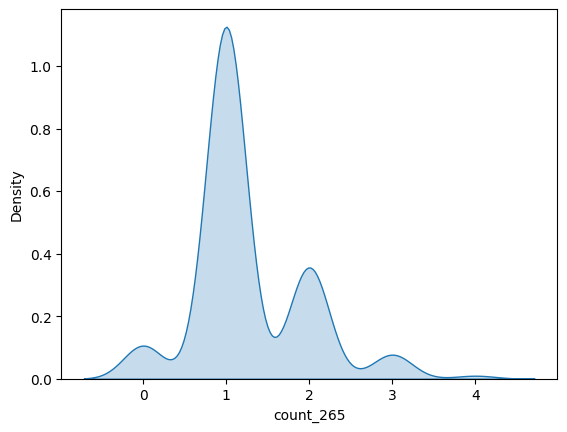

In [11]:
sns.kdeplot(df, x='count_265', clip=(-10, 50), fill=True);

Вывод:
- номенклатура 265:
    - среднее значение больше медианного - наблюдается правый перекос
    - график это подтверждает
- номенклатура 13653:
    - среднее значение равно медианному

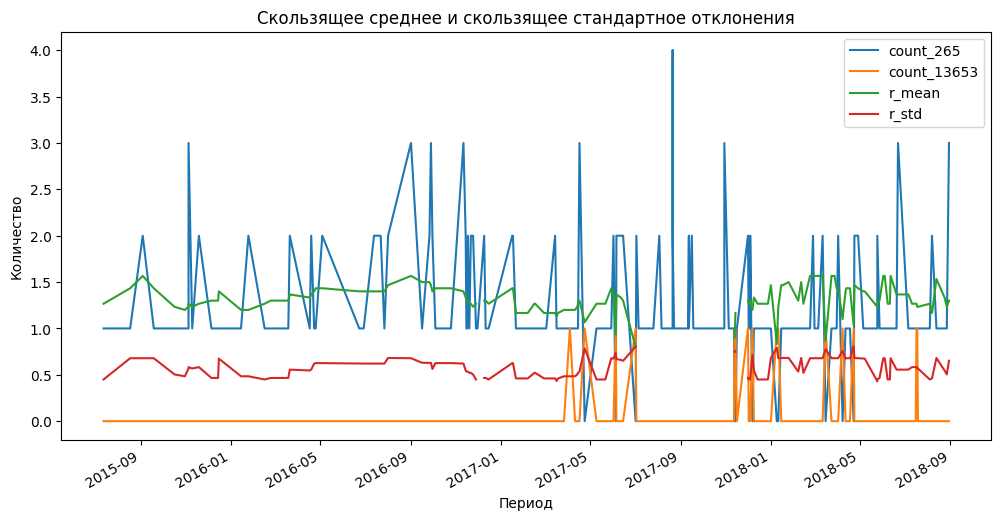

In [12]:
df_s = df.copy().set_index('date')

df_s['r_mean'] = df_s['count_265'].rolling(window=30).mean()
df_s['r_std'] = df_s['count_265'].rolling(window=30).std()

df_s.plot(figsize=(12,6))
plt.title('Скользящее среднее и скользящее стандартное отклонения')
plt.ylabel('Количество')
plt.xlabel('Период');

Суммарные продажи по месяцам

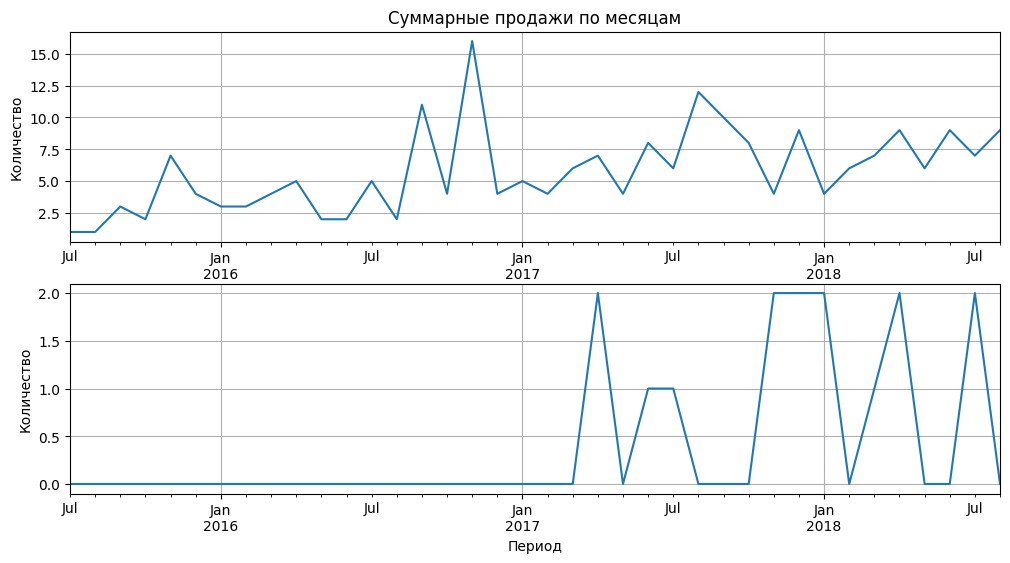

In [13]:
df_resample = df_s.resample('1M').sum()

plt.figure(figsize=(12,6))

plt.subplot(211)
df_resample['count_265'].plot(ax=plt.gca())
plt.title("Суммарные продажи по месяцам")
plt.ylabel("Количество")
plt.grid()

plt.subplot(212)
df_resample['count_13653'].plot(ax=plt.gca())
plt.xlabel("Период")
plt.ylabel("Количество")
plt.grid();

Вывод:
- явной сезонности не наблюдается

Изучение сезонности, тренда и остатков

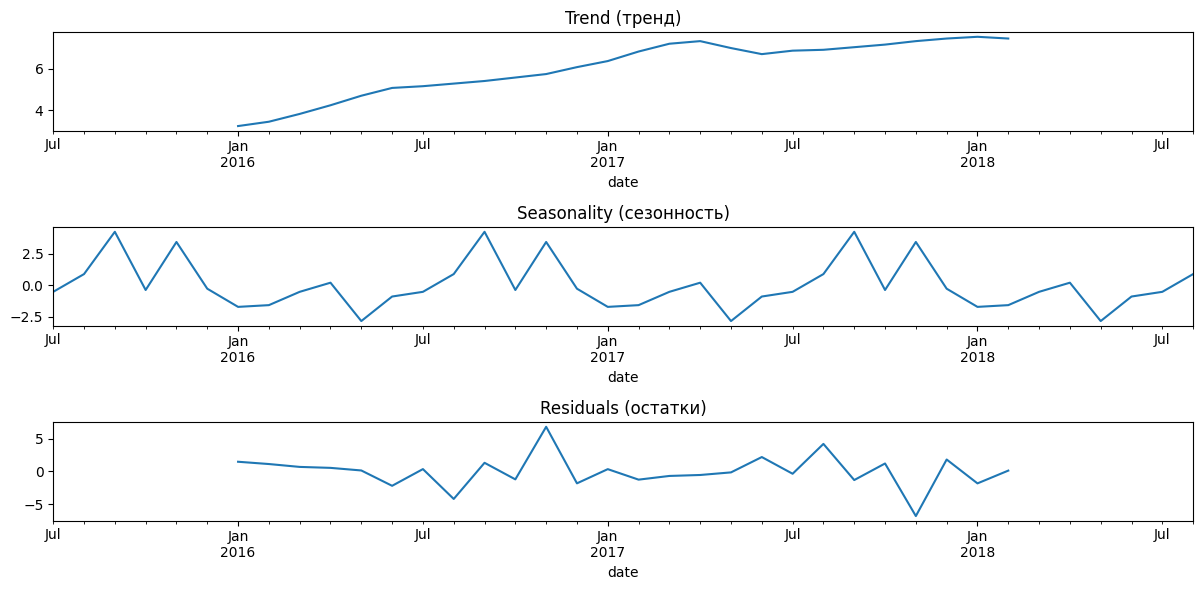

In [14]:
decomposed_df = seasonal_decompose(df_resample['count_265'])

plt.figure(figsize=(12,6))

plt.subplot(311)
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Trend (тренд)')

plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (сезонность)')

plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Residuals (остатки)')
plt.tight_layout()

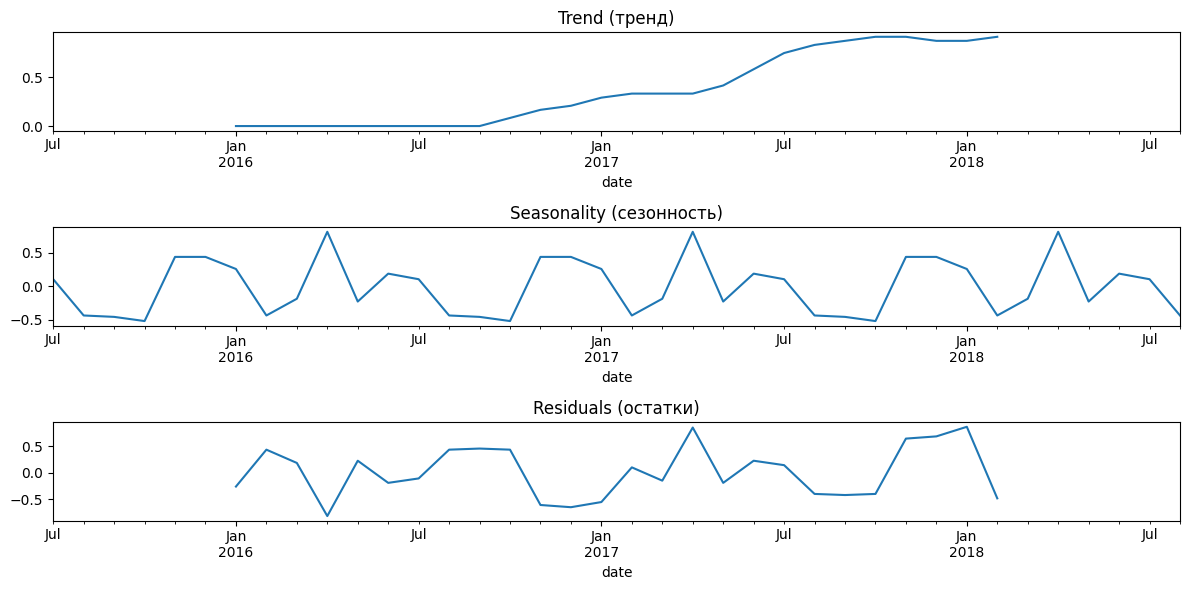

In [15]:
decomposed_df = seasonal_decompose(df_resample['count_13653'])

plt.figure(figsize=(12,6))

plt.subplot(311)
decomposed_df.trend.plot(ax=plt.gca())
plt.title('Trend (тренд)')

plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (сезонность)')

plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca())
plt.title('Residuals (остатки)')
plt.tight_layout()

Вывод:
- у обоих номенклатур наблюдается общий восходящий тренд
- по номенклатуре 265:
  - можно выделить пики продаж в сентябре и ноябре, значительный спад - в мае
- по номенклатуре 13653:
  - пики продаж - апрель, значительное снижение - октябрь

## Machine learning

### Прогноз высокочастотной номенклатуры

In [16]:
df_b = df[['date', 'count_265']].copy().rename(columns={'date': 'ds', 'count_265': 'y'})
df_b.sample(3)

,ds,y
89,2016-10-04,1.0
94,2016-09-01,3.0
61,2017-04-15,1.0


Обучение модели Prophet

09:08:23 - cmdstanpy - INFO - Chain [1] start processing
09:08:23 - cmdstanpy - INFO - Chain [1] done processing


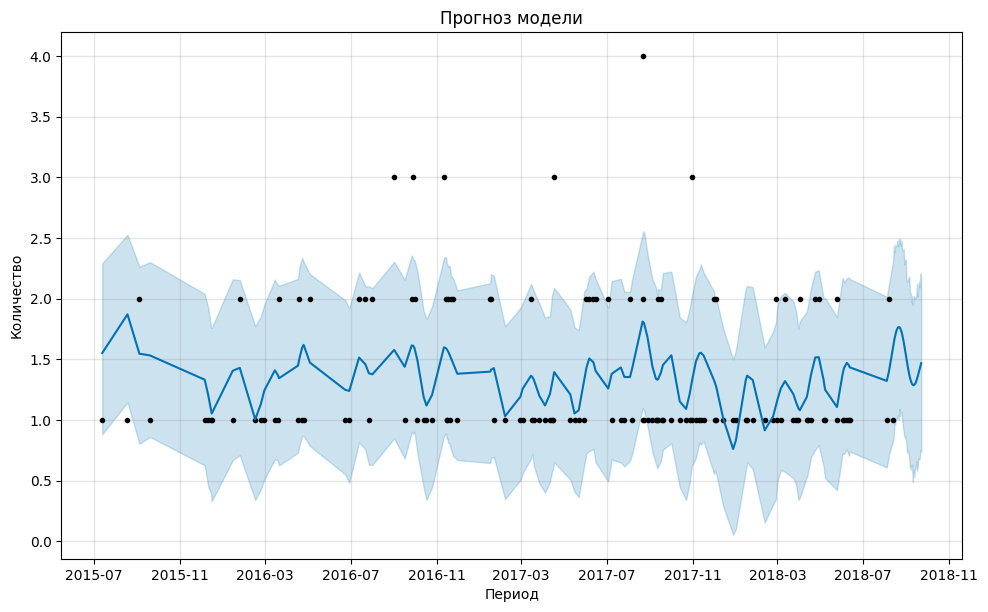

In [17]:
X_train_b = df_b[:-PRED_265]
X_test_b = df_b[-PRED_265:]

model_b = Prophet(daily_seasonality=False, #дневная сезонность
                   weekly_seasonality=False, #недельная сезонность
                   yearly_seasonality=True) #годовая сезонность

model_b.fit(X_train_b) # обучение модели

#получение предсказаний, отрисовка диаграммы
future_b = model_b.make_future_dataframe(periods=PRED_265)
forecast_b = model_b.predict(future_b)
model_b.plot(forecast_b)
plt.title("Прогноз модели")
plt.xlabel("Период")
plt.ylabel("Количество");

Вывод:

- чёрные точки - исходные данные,
- синяя линия - это модель прогноза,
- голубая область - доверительный интервал,
- по визуальному анализу можно сказать, что ошибки модели минимальны.

In [18]:
df_forecast_b = forecast_b.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_b.set_index('ds'))
df_forecast_b['buying_score'] = (1 + round((df_forecast_b['yhat'] + df_forecast_b['yhat_lower'])/2,0)) / (1 + df_forecast_b['y'])
                                     
print('buying_score:', round(np.mean(abs(df_forecast_b[-PRED_265:]['buying_score'])), 2))

buying_score: 0.83


### Прогноз низкочастотной номенклатуры

In [19]:
df_s = df[['date', 'count_13653']].copy().rename(columns={'date': 'ds', 'count_13653': 'y'})
df_s.sample(3)

,ds,y
104,2018-02-27,0.0
60,2017-04-17,0.0
140,2018-06-20,0.0


Обучение модели Prophet

09:08:24 - cmdstanpy - INFO - Chain [1] start processing
09:08:24 - cmdstanpy - INFO - Chain [1] done processing


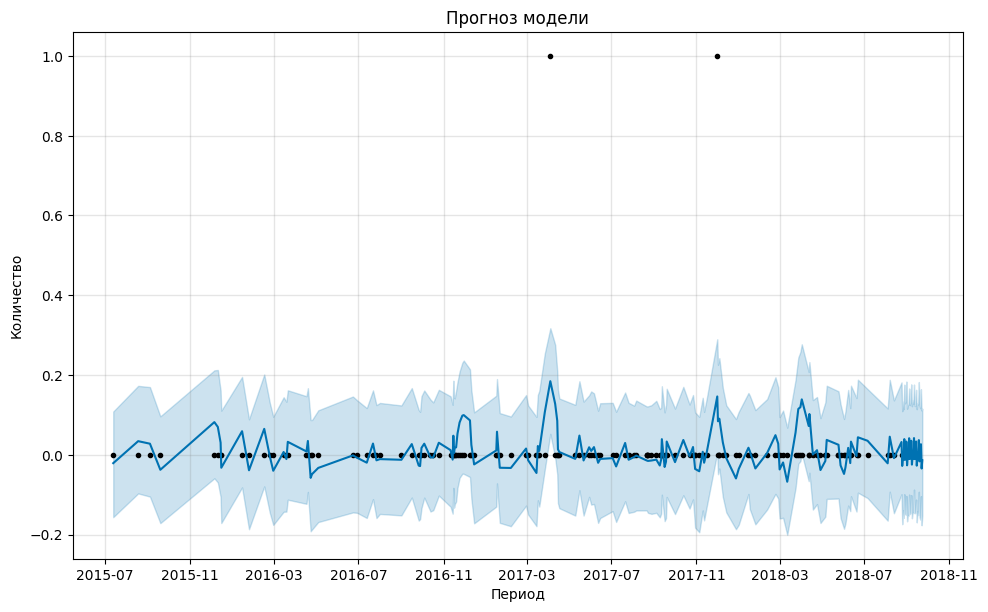

In [20]:
X_train_s = df_s[:-PRED_13653]
X_test_s = df_s[-PRED_13653:]

model_b = Prophet(daily_seasonality=False, #дневная сезонность
                   weekly_seasonality=True, #недельная сезонность
                   yearly_seasonality=True) #годовая сезонность

model_b.fit(X_train_s) # обучение модели

#получение предсказаний, отрисовка диаграммы
future_s = model_b.make_future_dataframe(periods=PRED_13653)
forecast_s = model_b.predict(future_s)
model_b.plot(forecast_s)
plt.title("Прогноз модели")
plt.xlabel("Период")
plt.ylabel("Количество");

In [21]:
df_forecast_s = forecast_s.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_s.set_index('ds'))
df_forecast_s['buying_score'] = (1 + df_forecast_s['yhat']) / (1 + df_forecast_s['y'])
                                     
print('buying_score:', round(np.mean(abs(df_forecast_s[-PRED_13653:]['buying_score'])), 2))

buying_score: 0.99


Заключение:
- для высокочастотной номенклатуры получена метрика `buying_score: 0.83`
- при расчёте использовано среднее значение между прогнозом и нижней границей доверительного интервала,
  <br>т.к. по условию лучше недозакуп: `buying score < 1`
- для низкочастотной номенклатуры получена метрика `buying_score: 0.99`
- **для прогнозирования продаж высокочастотной номенклатуры подойдёт модель `Prophet`**
- **для прогнозирования продаж низкочастотной номенклатуры нужны дополнительные данные, например -
  <br>срок изготовления продукта, его срок поставки.
  <br>Возможно, прогнозировать продажи этого товара и не требуется: его можно привозить клиенту под заказ.**